### imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from sklearn import tree

### Loading and sample data

Synthetic Transactions: https://www.kaggle.com/ntnu-testimon/paysim1

In [3]:
# Load file
dataset = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

trainset = dataset.sample(frac=0.5)
testset = dataset.sample(frac=0.5)

### Treat data

In [4]:
# Remove types that never are fraud
trainset = trainset.loc[trainset['type'] != 'PAYMENT']
trainset = trainset.loc[trainset['type'] != 'DEBIT']
trainset = trainset.loc[trainset['type'] != 'CASH_IN']

testset = testset.loc[testset['type'] != 'PAYMENT']
testset = testset.loc[testset['type'] != 'DEBIT']
testset = testset.loc[testset['type'] != 'CASH_IN']

# Map domain to numbers
trainset = trainset.replace("TRANSFER", 0)
trainset = trainset.replace("CASH_OUT", 1)

testset = testset.replace("TRANSFER", 0)
testset = testset.replace("CASH_OUT", 1)

# Treat step in hour, day and week
trainset['hour'] = trainset['step'].map(lambda x: x % 24)
trainset['day'] = trainset['step'].map(lambda x: int(x / 24))
trainset['week'] = trainset['step'].map(lambda x: int(x / 168))

testset['hour'] = testset['step'].map(lambda x: x % 24)
testset['day'] = testset['step'].map(lambda x: int(x / 24))
testset['week'] = testset['step'].map(lambda x: int(x / 168))

# Define labels
trainlabel = trainset['isFraud']
testlabel = testset['isFraud']

# Remove unused data
trainset = trainset.drop(columns=['nameOrig', 'nameDest', 'step', 'isFlaggedFraud', 'isFraud'])
testset = testset.drop(columns=['nameOrig', 'nameDest', 'step', 'isFlaggedFraud', 'isFraud'])

### Train dataset information

In [5]:
train_qtd = trainset.shape[0]
train_fraud_qtd = len(list(filter(lambda x: x == 1, trainset['isFraud'])))
train_nonfraud_qtd = len(list(filter(lambda x: x == 0, trainset['isFraud'])))
train_proportion = train_fraud_qtd / train_qtd

print('train_total:', train_qtd)
print('train_fraud:', train_fraud_qtd)
print('train_nonfraud', train_nonfraud_qtd)
print('train_fraud proportion', train_proportion)
trainset.head()

KeyError: 'isFraud'

### Test dataset information

In [6]:
test_qtd = testset.shape[0]
test_fraud_qtd = len(list(filter(lambda x: x == 1, testset['isFraud'])))
test_nonfraud_qtd = len(list(filter(lambda x: x == 0, testset['isFraud'])))
test_proportion = test_fraud_qtd / test_qtd

print('test_total:', test_qtd)
print('test_fraud:', test_fraud_qtd)
print('test_nonfraud', test_nonfraud_qtd)
print('test_fraud proportion', test_proportion)
testset.head()

test_total: 138572
test_fraud: 404
test_nonfraud 138168
test_fraud proportion 0.0029154518950437317


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week
3087168,235,1,115132.23,C428162982,628.0,0.0,C2023491838,28939.58,144071.82,0,0,19,9,1
204748,13,0,518835.55,C674781788,0.0,0.0,C1548549205,4490599.66,5009435.20,0,0,13,0,0
4081038,301,0,387724.00,C1698211699,0.0,0.0,C171792332,2017525.74,2405249.75,0,0,13,12,1
3972717,297,1,18859.51,C1613180007,0.0,0.0,C805356162,281974.60,300834.11,0,0,9,12,1
3428409,256,1,130203.66,C607973287,0.0,0.0,C1113831141,340484.25,470687.90,0,0,16,10,1


### Divide Fraud x NonFraud

In [7]:
train_frauds = trainset.loc[trainset['isFraud'] == 1]
train_non_frauds = trainset.loc[trainset['isFraud'] == 0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week
6074070,516,1,346293.24,C829436029,346293.24,0.00,C1738520779,750235.55,1096528.80,1,0,12,21,3
1030638,80,1,173782.59,C2085532500,173782.59,0.00,C1628486398,3272453.63,3446236.22,1,0,8,3,0
6118751,534,0,492896.75,C1728027611,492896.75,0.00,C1170151190,0.00,0.00,1,0,6,22,3
1291987,135,0,7927.06,C3592918,7927.06,0.00,C956442492,0.00,0.00,1,0,15,5,0
1059571,105,1,2988103.30,C1655503661,2988103.30,0.00,C1811125343,1402954.55,4391057.85,1,0,9,4,0
4785635,340,1,92145.40,C987947557,92145.40,0.00,C1630824313,388798.48,480943.88,1,0,4,14,2
3247297,250,0,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.00,0.00,1,1,10,10,1
3960321,295,1,4531343.47,C1462947577,4531343.47,0.00,C1069720,0.00,4531343.47,1,0,7,12,1
6065304,512,0,684266.09,C1873188115,684266.09,0.00,C315115812,0.00,0.00,1,0,8,21,3
1106653,130,1,201988.55,C768827256,201988.55,0.00,C136499939,0.00,201988.55,1,0,10,5,0


### Labs

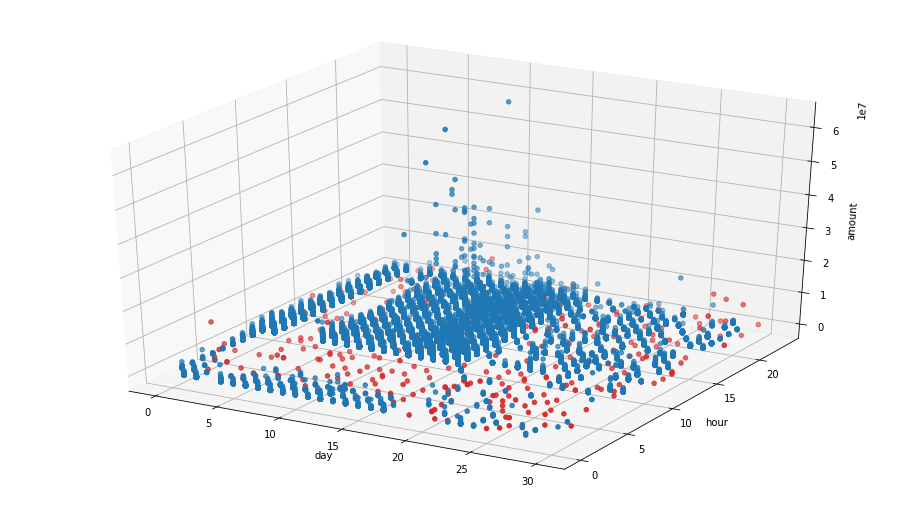

In [9]:
def plot(x_value, y_value, z_value):
    fig = plt.figure()
    fig.set_size_inches(16, 9)
    ax = fig.add_subplot(111, projection='3d')
    
    
    x_fraud = train_frauds[[x_value]]
    y_fraud = train_frauds[[y_value]]
    z_fraud = train_frauds[[z_value]]

    x_nonfraud = train_non_frauds[[x_value]]
    y_nonfraud = train_non_frauds[[y_value]]
    z_nonfraud = train_non_frauds[[z_value]]
    
    ax.scatter(x_fraud, y_fraud, z_fraud, c='C3')
    ax.scatter(x_nonfraud, y_nonfraud, z_nonfraud, c='C0')
    
    ax.set_xlabel(x_value)
    ax.set_ylabel(y_value)
    ax.set_zlabel(z_value)
    
plot('day', 'hour', 'amount')

### Learning

In [5]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(trainset, trainlabel)

### Evaluate

In [6]:
accuracy = clf.score(testset, testlabel)
print(accuracy)

0.9996245286751783
